In [3]:
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from neo4j import GraphDatabase
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import numpy as np

sns.set(font_scale = 1.5)

In [4]:
# Connect to Neo4j
driver = GraphDatabase.driver('bolt://localhost:7687', auth=('neo4j', 'letmein'))

def read_query(query):
    with driver.session() as session:
        result = session.run(query)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

# Agenda
In this blog post, I present how I used FastRP, a node embedding algorithm, as an input to an ML classifier. The idea is to predict the language in which a streamer is broadcasting based on the co-chatting network. We will assume that if a user is chatting in multiple streams, there is a high probability that those streamers broadcast in the same language. Then we will use FastRP embeddings to engineer features for our classification model. On a high level, this post can be split into the following steps:
* Data cleaning
* Infer co-chatting network
* FastRP embeddings
* Evaluate classification accuracy

# Data cleaning
We will start by exploring the dataset a bit. Let's first inspect the languages and how many streamers use them in their broadcast.

In [4]:
read_query("""
MATCH (l:Language)
RETURN l.name as language,
       size((l)<--()) as numberOfStreams
ORDER BY numberOfStreams
DESC
""")

,language,numberOfStreams
0,en,1867
1,es,347
2,de,303
3,ru,280
4,fr,276
5,ko,266
6,pt-br,208
7,en-gb,176
8,it,146
9,tr,139


There is a total of 30 different languages in our graph. We have to exclude some of the languages in our classification task due to their small sample size. I have decided to exclude all the languages that have fewer than 100 streamers.

In [6]:
read_query("""
MATCH (l:Language)
WHERE size((l)<--()) < 100
MATCH (l)<--(streamer)
SET streamer:Exclude
RETURN distinct 'success' as result
""")

,result
0,success


Next, we will check to see if any of the streamers broadcast in more than a single language.

In [7]:
read_query("""
MATCH (s:Stream)
WHERE size((s)-[:HAS_LANGUAGE]->()) > 1
MATCH (s)-[:HAS_LANGUAGE]->(l)
RETURN s.name as streamer, collect(l.name) as languages
""")

,streamer,languages
0,gige,"[hu, en]"


There is only one streamer who has assigned more than a single language. Gige broadcasts in English and Hungary languages. We have excluded all the languages with less than 100 streamers, which Hungary falls into, so we will ignore Gige in our further analysis.
Now, we will look at the users in our knowledge graph. It makes sense to plot the node out-degree distribution. The out-degree, in this case, informs us about the count of streams a user chatted in.

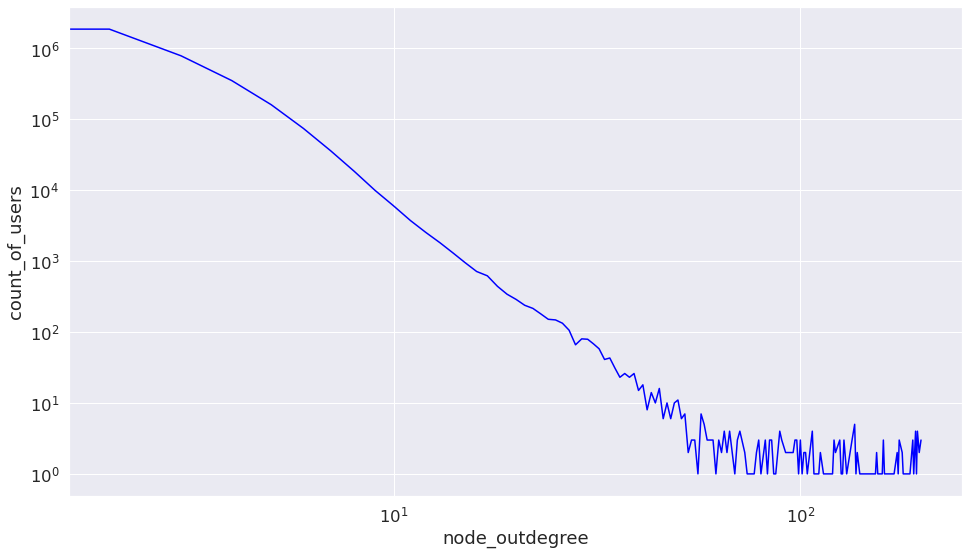

In [11]:
data = read_query("""
MATCH (u:User)
WHERE NOT u:Exclude
WITH u, size((u)-[:CHATTER|VIP|MODERATOR]->()) as node_outdegree
RETURN node_outdegree, count(*) as count_of_users
ORDER BY node_outdegree ASC""")

fig, ax = plt.subplots(figsize=(16,9))
ax = sns.lineplot(x="node_outdegree", y="count_of_users", data=data, color="blue")
ax.set_yscale("log")
ax.set_xscale("log")


There are around 5000 streamers in our database, so the maximum possible out-degree is 5000. The data was fetched over a period of three days. I would venture a guess that users who chatted in more than 1000 streams are highly likely to be bots. I chose 200 to be the actual threshold, so users who have talked in more than 200 streams over three days will be ignored. I think that even that is generous. You would have to chat in more than 60 streams per day to achieve this threshold.

In [10]:
read_query("""
MATCH (u:User)
WHERE NOT u:Exclude
WITH u, size((u)-[:CHATTER|VIP|MODERATOR]->()) as node_outdegree
WHERE node_outdegree > 200
SET u:Exclude
""")

""


It is also highly likely that the most active moderators are actually bots.

In [ ]:
# Just check moderators for some additional bots
read_query("""
MATCH (u:User)
WHERE NOT u:Exclude
RETURN u.name as user, size((u)-[:MODERATOR]->()) as mod_count
ORDER BY mod_count DESC LIMIT 50
""")

Seems my hypothesis was valid. Most of the highly active moderators have a bot in their name. We will also exclude moderators who have participated in more than 10 streams over the three days the data was fetched.

In [12]:
# Exclude users who moderate more than 10 channels
read_query("""
MATCH (u:User)
WHERE NOT u:Exclude
WITH u, size((u)-[:MODERATOR]->()) as mod_count
WHERE mod_count > 10
SET u:Exclude
RETURN distinct 'success' as result
""")

,result


# Train - test split

Before we do the train-test data split, let's quickly refresh how many data points per language there are.

In [13]:
read_query("""
MATCH (l:Language)<-[:HAS_LANGUAGE]-(s:Stream)
WHERE NOT s:Exclude
RETURN l.name as language, count(*)
""")

,language,count(*)
0,en,1659
1,en-gb,157
2,fr,244
3,it,137
4,ko,238
5,ru,244
6,es,300
7,de,272
8,zh-tw,102
9,pt-br,181


By far, the most frequent language is English. Next, there are Spanish, German, and Russian. For some reason, Twitch decided to distinguish between English and United Kingdom English. We will not make that differentiation in our classification task and treat both of them as the same. Instead, we will write the language as the node property, combining English and UK English into a single category.

In [15]:
read_query("""
MATCH (s:Stream)-[:HAS_LANGUAGE]->(l:Language)
WHERE NOT s:Exclude
SET s.language = CASE WHEN l.name = 'en-gb' THEN 'en' ELSE l.name END
""")

""


We will use 80% of the data points per language as the training set and leave the other 20% for testing.

In [16]:
read_query("""
MATCH (s:Stream)
WHERE NOT s:Exclude
WITH s.language as language, s
ORDER BY s.name
WITH language, count(*) as count, collect(s) as streamers
WITH language, streamers, toInteger(count * 0.8) as training_size
UNWIND streamers[..training_size] as train_data
SET train_data:Train
""")

""


I have added the order by name line for easier reproducibility. Of course, you can use any random function to split the train-test dataset if you want.

# Infer co-chatter network

We have two options to project an in-memory graph. Here, we will use the Cypher projection feature. Cypher projection is the more flexible way of projecting an in-memory graph but comes with a small loading performance cost. I have written an exhaustive blog about using Cypher projections, but for now, it is enough to know that we use the first Cypher statement to project nodes and the second Cypher statement to project the relationships of the in-memory graph.

In [18]:
read_query("""
CALL gds.graph.create.cypher("twitch",
"MATCH (u:User) WHERE NOT u:Exclude RETURN id(u) as id, labels(u) as labels, coalesce(u.followers,0) as followers, coalesce(u.total_view_count,0) as total_view_count",
"MATCH (s:User)-->(t:Stream)
 WHERE NOT s:Exclude AND NOT t:Exclude
 RETURN id(t) as source, id(s) as target",
{validateRelationships:false})
""")

,nodeQuery,relationshipQuery,graphName,nodeCount,relationshipCount,createMillis
0,MATCH (u:User) WHERE NOT u:Exclude RETURN id(u...,MATCH (s:User)-->(t:Stream)\n WHERE NOT s:Excl...,twitch,4271897,7647926,19017


In the first statement, we have projected all the User nodes that weren't tagged with Exclude secondary label. Adding the labels of the nodes allows us to filter nodes at algorithm execution time. This will enable us to filter only Stream nodes when calculating FastRP embeddings. We have also included the follower and total_view_count node properties. In the second statement, we project all the relationships between users and streamers. Those relationships indicate which users have chatted in a specific streamer's broadcast.
To infer the co-chatting network between streamers, we will use the Node Similarity algorithm. Node Similarity algorithm uses the Jaccard similarity score to compare how similar a pair of nodes is based on the number of shared chatters.

As mentioned, the more common chatters a pair of streamers have, the more we will deem them similar. We will name the resulting relationship SHARED_AUDIENCE, which is precisely what we are doing in this case, evaluating shared audiences of streamers. The Node Similarity algorithm has two very important hyper-parameters that need to be tuned:
* TopK: Number of stored relationships for a node. The top K relationships by similarity score will be stored.
* SimilarityCutoff: Lower limit for the similarity score to be present in the result. Any relationships with a score lower than the similarityCutoff will be automatically ignored in results.

I always like to start by first evaluating the similarity score distribution using the stats mode of the algorithm.

In [19]:
read_query("""
CALL gds.nodeSimilarity.stats("twitch")
""")['similarityDistribution'].to_list()

[{'p1': 0.0005675404972862452,
  'max': 1.0000076293654274,
  'p5': 0.002954214782221243,
  'p90': 0.058524370164377615,
  'p50': 0.014385879010660574,
  'p95': 0.08700561520527117,
  'p10': 0.004273533792002127,
  'p75': 0.030665039987070486,
  'p99': 0.189642906159861,
  'p25': 0.007166147202951834,
  'p100': 1.0000076293654274,
  'min': 5.443114787340164e-06,
  'mean': 0.02655834522612726,
  'stdDev': 0.040834074257494656}]

We get the distribution in the form of percentile values. On average, a pair of streamers share around 3% of users. Only 10% of streamers share more than 6% of users. On average, streamers don't share a lot of their audience. This is probably skewed a bit because the data was retrieved only over 3 days, and only the users who have engaged in the chat are considered. We will leave the similarityCutoff parameter at the default value of 1E-42, which is a very tiny number, but slightly bigger than 0. Relationships will be considered between a pair of streamers when they share at least one user. Now, we have to decide on the topK value. The topK parameter heavily influences how dense or sparse will the resulting monopartite projection be. With a bit of trial and error, I have decided to use the topK value of 25.

In [6]:
read_query("""
CALL gds.nodeSimilarity.mutate("twitch", 
  {topK:25, mutateProperty:'score', mutateRelationshipType:'SHARED_AUDIENCE'})

""")

,createMillis,computeMillis,mutateMillis,postProcessingMillis,nodesCompared,relationshipsWritten,similarityDistribution,configuration
0,1,55905,172,-1,4105,101009,"{'p1': 0.0003668386198114604, 'max': 1.0000076...","{'topK': 25, 'bottomK': 10, 'bottomN': 0, 'rel..."


# FastRP embeddings

In [16]:
def tsne(query, hue):
    embeddings = read_query(query)

    tsne = TSNE(n_components=2, n_iter=300)
    tsne_results = tsne.fit_transform(embeddings['embedding'].to_list())

    embeddings['tsne_x'] = [x[0] for x in list(tsne_results)]
    embeddings['tsne_y'] = [x[1] for x in list(tsne_results)]

    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="tsne_x", y="tsne_y",
        hue=hue,
        palette=sns.color_palette("hls", 10),
        data=embeddings,
        legend="full",
        alpha=0.9
    )


Node embedding algorithms calculate a fixed-size vector or embedding representation of a node in a graph. This is very useful when we want to use the network features in our downstream machine learning workflow.
We can easily retrieve FastRP embeddings of nodes by using the following Cypher query.

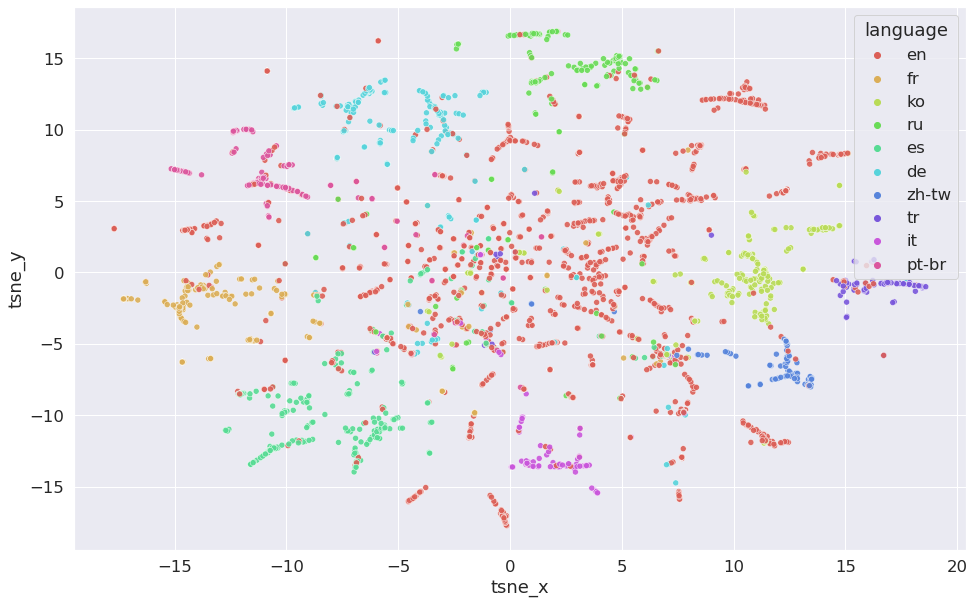

In [17]:
tsne("""
CALL gds.fastRP.stream(
  "twitch",
  {nodeLabels:['Stream'], relationshipTypes:['SHARED_AUDIENCE'],
   relationshipWeightProperty:'score', embeddingDimension: 64}
) YIELD nodeId, embedding
WITH gds.util.asNode(nodeId) as node, nodeId, embedding
RETURN nodeId, embedding, node.language as language
""", "language")

The data points are colored based on their language. Just by looking at the scatter plot, it is evident that the node embeddings capture the language of the stream quite well. It seems that only the English language is a bit all over the place, while other minor languages form lovely clusters.
# Classification task evaluation
Finally, let's examine how well we can predict broadcast language based on the FastRP embeddings. We have already done the train-test split in the previous step, so the only thing left to do is to export those embeddings and input them into a classification model. We will use the Random Forest classifier in this example. I prepared a helper function that will take in a cypher query and return a classification report and confusion matrix as the output.

In [18]:
def evaluate(y_true,y_pred):
  labels = set(y_true)
  print("Overall f1 score: {}".format(f1_score(y_true, 
               y_pred, average="micro")))
  print(classification_report(y_true,y_pred))
  cm = confusion_matrix(y_true,y_pred)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmat = pd.DataFrame(cm)
  cmat.columns = labels
  fig, ax = plt.subplots(figsize=(16,9))
  #cmat.set_index([pd.Index(labels, '')],inplace=True)
  ax = sns.heatmap(cmat,cmap="YlGnBu", annot=True)
  plt.title("Confusion Matrix")

def classify_and_evaluate(query):
    embeddings = read_query(query)

    embeddings['output'] = pd.factorize(embeddings['language'])[0]
    train_data = embeddings[embeddings['split'] == 'train']
    test_data = embeddings[embeddings['split'] == 'test']
    rf_classifier = RandomForestClassifier()
    rf_classifier.fit(train_data['embedding'].to_list(), train_data['output'].to_list())
    rf_predictions = rf_classifier.predict(test_data['embedding'].to_list())
    evaluate(test_data['output'].to_list(), rf_predictions)
    

Now we can go ahead and input the same query we used above to generate a classification report.

Overall f1 score: 0.8600723763570567
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       409
           1       0.91      0.88      0.89        56
           2       1.00      0.74      0.85        54
           3       0.87      0.73      0.80        56
           4       0.94      0.84      0.89        70
           5       0.87      0.79      0.83        61
           6       0.96      1.00      0.98        23
           7       0.85      0.79      0.81        28
           8       0.92      0.80      0.86        30
           9       0.90      0.67      0.77        42

    accuracy                           0.86       829
   macro avg       0.90      0.82      0.85       829
weighted avg       0.87      0.86      0.86       829



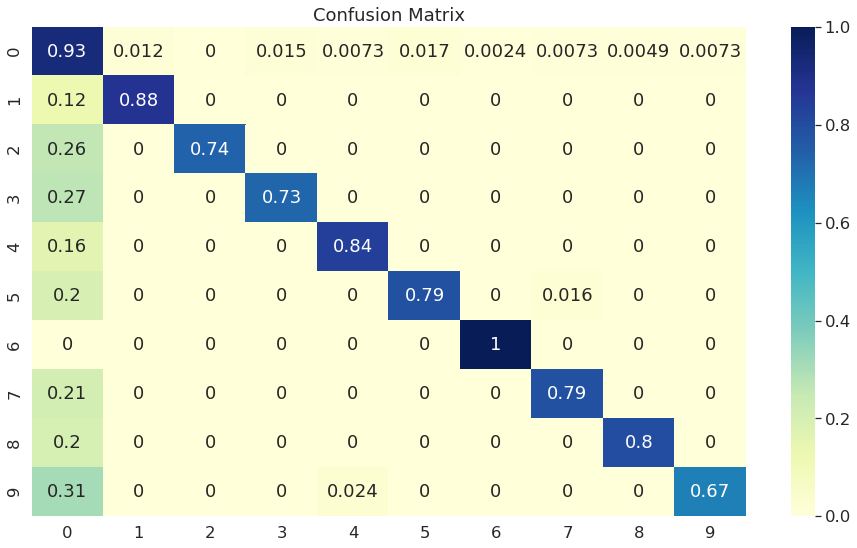

In [19]:
classify_and_evaluate("""
CALL gds.fastRP.stream(
  "twitch",
  {nodeLabels:['Stream'], relationshipTypes:['SHARED_AUDIENCE'],
   relationshipWeightProperty:'score', embeddingDimension: 64}
) YIELD nodeId, embedding
WITH gds.util.asNode(nodeId) as node, nodeId, embedding
RETURN nodeId, embedding, node.language as language, CASE WHEN node:Train then 'train' else 'test' END as split
""")

Without any fine-tuning of the FastRP or Random Forest algorithms hyper-parameters, we get an f1 score of 86%. That is very awesome. It seems like our hypothesis that chatters usually chat in streams that share the same language is valid. We can observe that the model only misclassified between English and minor languages by examining the confusion matrix. For example, the model never wrongly classified Korean as Portugal language. This makes sense as English is the language of the internet, and so everybody can speak at least their native language and a bit of English.
Now, we will try to optimize the FastRP algorithm hyper-parameters to achieve better accuracy.
# Relationship weights
I have used the relationship weights in the previous query as we have them available from the Node Similarity algorithm. We can input them with the relationshipWeightProperty parameter. After playing around with the settings, I have noticed that ignoring the relationship weight property produces better results.

Overall f1 score: 0.887816646562123
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       409
           1       0.93      0.89      0.91        56
           2       0.98      0.81      0.89        54
           3       0.88      0.75      0.81        56
           4       0.92      0.93      0.92        70
           5       0.91      0.84      0.87        61
           6       0.96      1.00      0.98        23
           7       0.80      0.86      0.83        28
           8       0.93      0.83      0.88        30
           9       0.92      0.86      0.89        42

    accuracy                           0.89       829
   macro avg       0.91      0.87      0.89       829
weighted avg       0.89      0.89      0.89       829



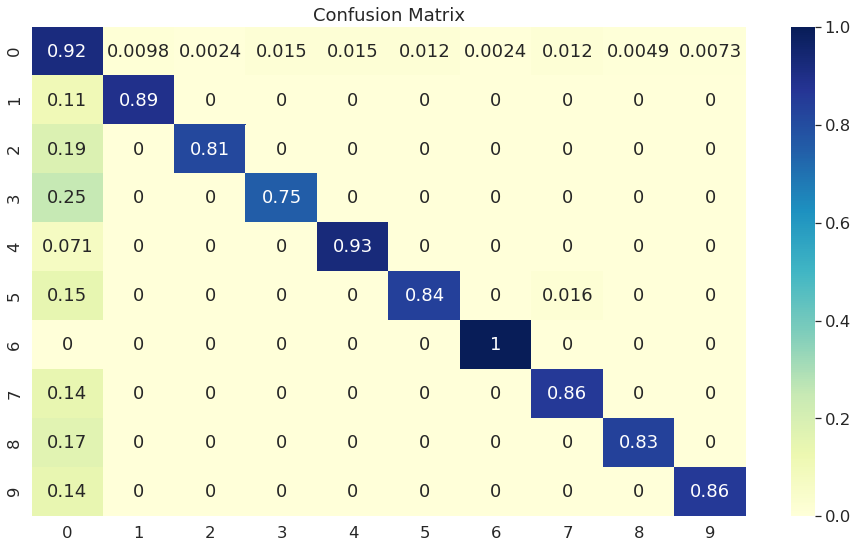

In [21]:
classify_and_evaluate("""
CALL gds.fastRP.stream(
  "twitch",
  {nodeLabels:['Stream'], relationshipTypes:['SHARED_AUDIENCE'],embeddingDimension: 64}
) YIELD nodeId, embedding
WITH gds.util.asNode(nodeId) as node, nodeId, embedding
RETURN nodeId, embedding, node.language as language, CASE WHEN node:Train then 'train' else 'test' END as split
""")

Now, there is nothing that implies that ignoring relationship weights will always produce better results. You should test it on your dataset and compare the results to make the final decision.
# Embedding dimension
The embedding dimension hyper-parameter defines the size of the output vector or embedding. I have found some general guidelines in the documentation:
>The optimal embedding dimension depends on the number of nodes in the graph. Since the amount of information the embedding can encode is limited by its dimension, a larger graph will tend to require a greater embedding dimension. A typical value is a power of two in the range 128–1024. A value of at least 256 gives good results on graphs in the order of 105 nodes, but in general increasing the dimension improves results. Increasing embedding dimension will however increase memory requirements and runtime linearly.

Even though our graph is quite small with only 5000 streamers, I have decided to test results for different embedding dimension parameters. It seems that increasing the embedding dimension parameter to 512 yields better results.

Overall f1 score: 0.893848009650181
              precision    recall  f1-score   support

           0       0.87      0.92      0.90       409
           1       0.92      0.86      0.89        56
           2       0.98      0.81      0.89        54
           3       0.88      0.80      0.84        56
           4       0.92      0.93      0.92        70
           5       0.93      0.82      0.87        61
           6       0.96      1.00      0.98        23
           7       0.81      0.89      0.85        28
           8       0.93      0.87      0.90        30
           9       0.93      0.90      0.92        42

    accuracy                           0.89       829
   macro avg       0.91      0.88      0.89       829
weighted avg       0.90      0.89      0.89       829



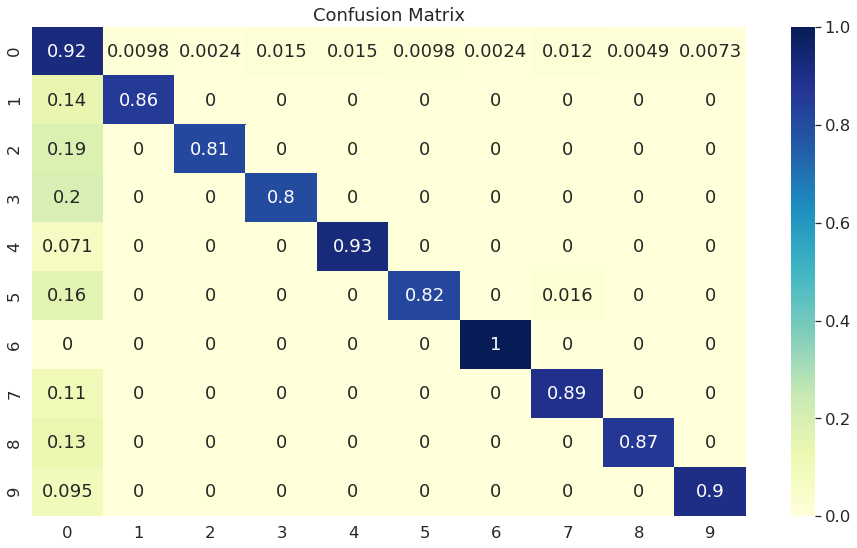

In [23]:
classify_and_evaluate("""
CALL gds.fastRP.stream(
  "twitch",
  {nodeLabels:['Stream'], relationshipTypes:['SHARED_AUDIENCE'],
   embeddingDimension: 512}
) YIELD nodeId, embedding
WITH gds.util.asNode(nodeId) as node, nodeId, embedding
RETURN nodeId, embedding, node.language as language, CASE WHEN node:Train then 'train' else 'test' END as split
""")

# Iteration Weights
The next hyper-parameter we can tune is the iteration weight. The documentation states the following:
>The iteration weights parameter control two aspects: the number of iterations, and their relative impact on the final node embedding. The parameter is a list of numbers, indicating one iteration per number where the number is the weight applied to that iteration.

After playing around a bit with the iteration weights parameters, I have found that using the following value increases the accuracy even more.

Overall f1 score: 0.902291917973462
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       409
           1       0.93      0.89      0.91        56
           2       0.98      0.87      0.92        54
           3       0.87      0.82      0.84        56
           4       0.91      0.97      0.94        70
           5       0.91      0.84      0.87        61
           6       0.96      1.00      0.98        23
           7       0.81      0.89      0.85        28
           8       0.90      0.87      0.88        30
           9       0.93      0.90      0.92        42

    accuracy                           0.90       829
   macro avg       0.91      0.90      0.90       829
weighted avg       0.90      0.90      0.90       829



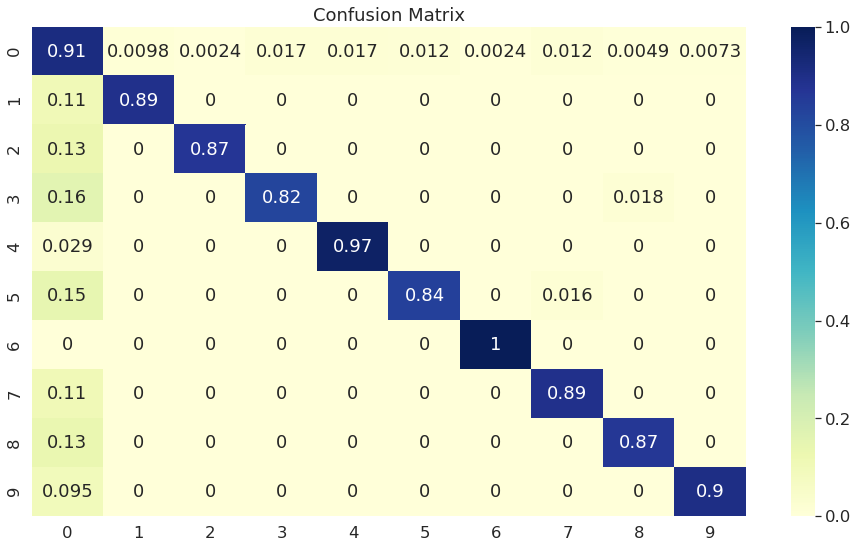

In [24]:
classify_and_evaluate("""
CALL gds.fastRP.stream(
  "twitch",
  {nodeLabels:['Stream'], relationshipTypes:['SHARED_AUDIENCE'],
   embeddingDimension: 512,
   iterationWeights:[0.1, 0.5, 0.9, 1.0, 1.0]}
) YIELD nodeId, embedding
WITH gds.util.asNode(nodeId) as node, nodeId, embedding
RETURN nodeId, embedding, node.language as language, CASE WHEN node:Train then 'train' else 'test' END as split
""")

# Normalization Weight
Another parameter that could be optimized is the normalization weight. Again the documentation states:
>The normalization strength is used to control how node degrees influence the embedding. Using a negative value will downplay the importance of high degree neighbors, while a positive value will instead increase their importance. The optimal normalization strength depends on the graph and on the task that the embeddings will be used for.

In our case, it doesn't make sense to try to optimize this parameter, as all the nodes should have exactly the same degree of 25. If you remember, we have used the Node Similarity algorithm with the topK value of 25, meaning that each node will be connected to its top 25 neighbors.
# Using node properties
The FastRP algorithm can be extended to also take into account node properties. I have noticed that if we add the followers count into consideration, the classification accuracy increases ever so slightly. Seems like the follower count might help to differentiate between English and other languages. My guess is that the English streamers have a higher count of followers, but that is just a hunch.

Overall f1 score: 0.9034981905910737
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       409
           1       0.93      0.89      0.91        56
           2       0.98      0.89      0.93        54
           3       0.87      0.84      0.85        56
           4       0.92      0.96      0.94        70
           5       0.91      0.82      0.86        61
           6       0.96      1.00      0.98        23
           7       0.81      0.89      0.85        28
           8       0.93      0.87      0.90        30
           9       0.93      0.90      0.92        42

    accuracy                           0.90       829
   macro avg       0.91      0.90      0.90       829
weighted avg       0.90      0.90      0.90       829



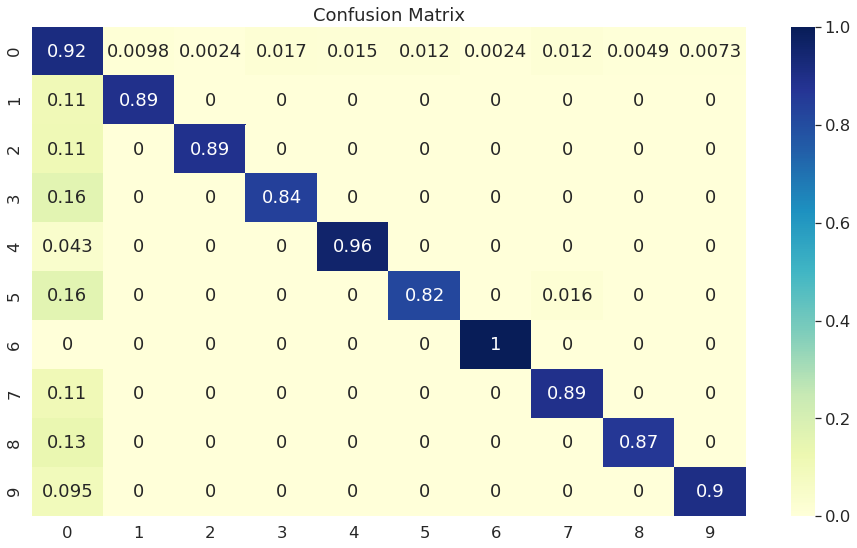

In [26]:
classify_and_evaluate("""CALL gds.beta.fastRPExtended.stream(
  "twitch",
  {nodeLabels:['Stream'], relationshipTypes:['SHARED_AUDIENCE'],
   embeddingDimension: 512, featureProperties: ['followers'],
   iterationWeights:[0.1, 0.5, 0.9, 1.0, 1.0]}
) YIELD nodeId, embedding
WITH gds.util.asNode(nodeId) as node, nodeId, embedding
RETURN nodeId, embedding, node.language as language, CASE WHEN node:Train then 'train' else 'test' END as split
""")

# Conclusion
We have managed to get a whopping 90% f1 score using only network features and nothing else. I think that this is very awesome and lends itself to solve other tasks, whereby looking at the relationship between data points might deliver very accurate results.